In [2]:
import os
dirpath = os.getcwd()
path=dirpath + '/img-060705-17.10.14-p-018t000.jpg'

'''from IPython.display import display
from PIL import Image

display(Image.open(path))


from PIL import Image
im = Image.fromarray(image)
im.save("your_file.jpeg")
'''
import numpy as np
import matplotlib.pyplot as plt
import cv2

'''import os
os.listdir()'''

def focus_gen():
    return none

def map_disp(mapmat):
    # Scales to visualizable CVS
    return none

class Scene:
    # Class stores image pixels paired with depth values of ambiguous scale.
    def __init__(self, img, mapmat):
        self.chans = (img, __improve(mapmat))
        return self
    
    def __improve(mapmat):
    # Requires subclass implementation per dataset, result should be double distance values from 0 to 1
        return mapmat

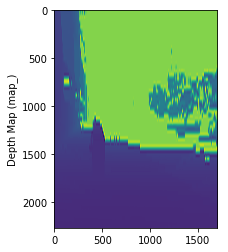

In [3]:
from scipy.io import loadmat
x = loadmat(dirpath + '/depth_sph_corr-060705-17.10.14-p-018t000.mat')
positions = x['Position3DGrid']

(mapH, mapW, x) = positions.shape
result = np.zeros((mapH,mapW))
for i in range(0, mapH):
    for j in range(0, mapW):
        result[i][j] = positions[i][j][3]

img = cv2.imread(path)
map_ = cv2.resize(result, dsize=(img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
plt.imshow(map_)
cv2.normalize(map_,map_,0,1,cv2.NORM_MINMAX)
plt.ylabel('Depth Map (map_)')
plt.show()

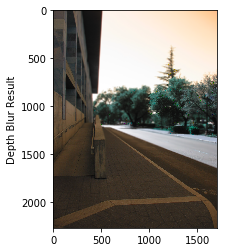

In [5]:
def make_disc_kernel(radius):
    '''
    Function produces a flat disc filter,
    Meant to mimic camera Bokeh
    '''
    x = np.arange(-radius, radius - 1)
    y = np.arange(-radius, radius - 1)
    xx, yy = np.meshgrid(x, y, sparse=True)
    disc = np.ones((radius*2-1,radius*2-1))
    disc[(xx+1)**2+(yy+1)**2 >= (1.0*radius)**2] = 0
    return disc/np.sum(disc)

def gamma_corrector(img, gamma):
    '''
    Function takes image and applies
    gamma
    '''
    img = img/255.0
    img = np.power(img, gamma)
    img = img*255
    return img.astype(np.uint8)

def depth_based_blur(img, map_, max_kernel = 10, skip = 2):
    thresh = 0
    kernel_shrink = max_kernel - 1

    layer_old = np.zeros(img.shape)
    while (kernel_shrink > 0):
        threshold_indices = map_ < thresh
        layer = np.copy(img)
        layer[threshold_indices] = 0
        mask = layer == 0
        img_gam = gamma_corrector(img,4)
            # Gamma step increases bokeh in highlights, emulating real photos
        bokeh_kernel = make_disc_kernel(max_kernel - kernel_shrink)
        layer = cv2.filter2D(img, 8, bokeh_kernel)
        gamma_layer = cv2.filter2D(img_gam, 8, bokeh_kernel)
        layer[layer < gamma_layer] = gamma_layer[layer < gamma_layer]
            # Takes high gamma bokeh while keeping original gamma for majority of the image
        layer[np.nonzero(mask)] = layer_old[np.nonzero(mask)]
        layer_old = np.copy(layer)
        thresh += 1.0/(max_kernel/skip)
        kernel_shrink -= skip
    return layer

layer = depth_based_blur(img, map_)

plt.imshow(layer)
plt.ylabel('Depth Blur Result')
plt.show()

from PIL import Image
im = Image.fromarray(layer)
im.save("your_file.jpeg")

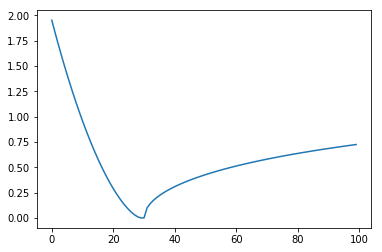

In [115]:

def make_blur_LUT(focus_plane = 30, falloff = .1):
    '''
    Returns a LUT spanning ambiguous distance
    of 0 to 1
    '''
    dist = np.arange(0, 1, .01)
    x = np.exp(-((dist-focus_plane/100.0)**2)/(2*(falloff**2)))
    '''    x = x/np.amax(x)
    x = 1 - x'''
    roll = np.arange(focus_plane/100.0, 1, .01)
    front = np.arange(0, focus_plane/100.0, .01)
    
    log = np.log(roll+(1-focus_plane/100.0))**.5
    #para = 20*(front-focus_plane/100.0)**2
    para = 10*np.flip(np.exp(front)-1)**1.5
    dist = np.concatenate((para,log))
    '''term = log[focus_plane]
    log[:focus_plane] = np.arange(0.0,term,term/(focus_plane))
    x += log'''
    return dist

dist = make_blur_LUT()
plt.plot(dist)
plt.show()